# Introduction


![alt text](https://raw.githubusercontent.com/Fournierp/OCR/master/Digit%20Recognition/digits.png)

# Imports

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.ndimage as ndimage
import cv2

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools

from collections import Counter

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
import tensorflow as tf

# Data Preprocessing

## Normalization & Reshape

To avoid exploding gradients in our CNN, we will normalize our data.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


Compute the dataset information.

In [ ]:
label_distribution = Counter(y_train)
dataset_length = x_train.shape[0]

# Exploratory Data Analysis

Let us now look at our data. 

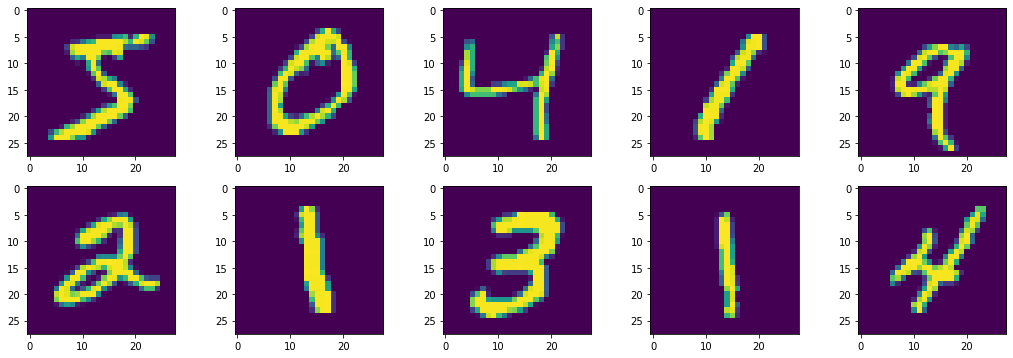

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))

g = ax1.imshow(x_train[0][:, :, 0])
g = ax2.imshow(x_train[1][:, :, 0])
g = ax3.imshow(x_train[2][:, :, 0])
g = ax4.imshow(x_train[3][:, :, 0])
g = ax5.imshow(x_train[4][:, :, 0])
g = ax6.imshow(x_train[5][:, :, 0])
g = ax7.imshow(x_train[6][:, :, 0])
g = ax8.imshow(x_train[7][:, :, 0])
g = ax9.imshow(x_train[8][:, :, 0])
g = ax10.imshow(x_train[9][:, :, 0])

From the sampled digits, we can deduce that the images are not filled with noise.

We will now graph the average digit per label of the training data.

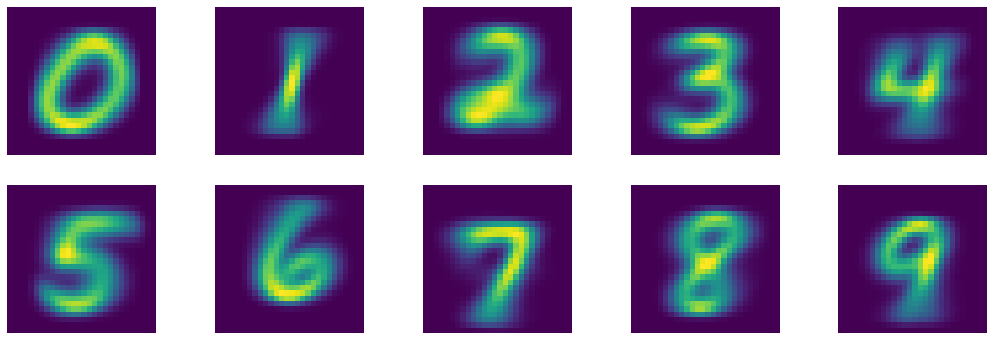

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))
ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off'), ax5.axis('off'),
ax6.axis('off'), ax7.axis('off'), ax8.axis('off'), ax9.axis('off'), ax10.axis('off'), 

digit = x_train[y_train == 0]
g = ax1.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 1]
g = ax2.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 2]
g = ax3.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 3]
g = ax4.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 4]
g = ax5.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 5]
g = ax6.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 6]
g = ax7.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 7]
g = ax8.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 8]
g = ax9.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 9]
g = ax10.imshow(np.average(digit, 0)[:, :, 0])

We can interpret these graphs to be the conclusive pixels in an image: pixels that will be interpreted by the Neural Network to classify digits. We can observe that each digit has some dead pixels, pixels that are not lit up. We can further observe that some pixels are not used by any digit (the corners for instance). Thus we ought to perform some Dimentionality Reduction to reduce the size of the data that will be fed to the Neural Network.
## Dimensionality Reduction
Let us explore Principle Component Analysis to reduce the number of features in our MNIST Data. In short PCA is a method of selecting the fewest Components (or features) that capture maximum variance. Firstly, we will select the best features (Principle Component) in our data such that they make up 95% of the Variance in the data. Then we will reconstruct our images from the selected Principle Components.

In [ ]:
pca = PCA(.95)
lower_dimensional_train = pca.fit_transform(x_train.reshape(-1, 28*28))
lower_dimensional_test = pca.transform(x_test.reshape(-1, 28*28))
pca.n_components_

154

In [ ]:
# Reconstruct
approximation_train = pca.inverse_transform(lower_dimensional_train)
approximation_test = pca.inverse_transform(lower_dimensional_test)

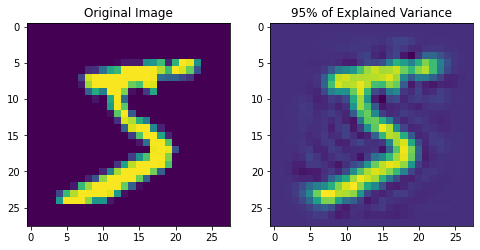

In [ ]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(x_train[0, :, :, 0]);
plt.title('Original Image');

# Principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation_train[0].reshape(28, 28));
plt.title('95% of Explained Variance');

In [ ]:
x_train = approximation_train.reshape(-1, 28, 28, 1)
test_df = approximation_test.reshape(-1, 28, 28, 1)

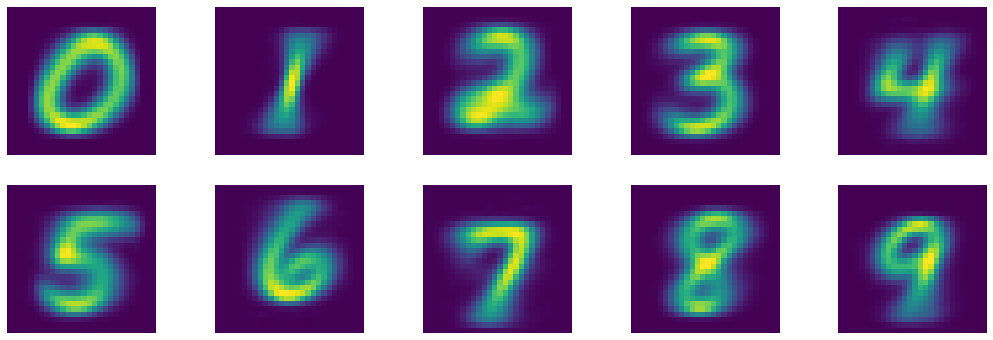

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(18, 6))
ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off'), ax5.axis('off'),
ax6.axis('off'), ax7.axis('off'), ax8.axis('off'), ax9.axis('off'), ax10.axis('off'), 

digit = x_train[y_train == 0]
g = ax1.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 1]
g = ax2.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 2]
g = ax3.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 3]
g = ax4.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 4]
g = ax5.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 5]
g = ax6.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 6]
g = ax7.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 7]
g = ax8.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 8]
g = ax9.imshow(np.average(digit, 0)[:, :, 0])
digit = x_train[y_train == 9]
g = ax10.imshow(np.average(digit, 0)[:, :, 0])

## Categorization

The activation function of the last layer of our CNN will be a softmax function (which will tell the level of certainty with witch the model is about the categorization), so we will one hot encode the categories to achieve better results.

In [ ]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

batch_size=32

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

dataset_val = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_val = dataset_val.batch(batch_size)

## Data Augmentation

This step is made to generate a new set of data to train the model on from the given data. <br>
Depending on the handwritting, the orientation of number will differ, we need our model to capture the different orientations so we will create additional images from original ones rotating them. In addition, some numbers can be recognized when flipped horizontally and/or vertically, like zero or eight, but some others could be confused with others, like a six and nine. To avoid deceiving the model, we will just rotate, zoom and shift on the original data.

In [ ]:
augment_prob = 0.25

def random_zoom_image(image):
    if augment_prob  > np.random.uniform():
        # Randomly zoom in or out
        if np.random.uniform() > 0.5:
            zoomfactor = np.random.uniform(0.7, .9)
        else:
            zoomfactor = np.random.uniform(1.1, 1.3)
        zoomfactor = np.random.uniform(1.1, 1.3)

        out  = np.zeros_like(image)
        zoomed = cv2.resize(image.numpy(), None, fx=zoomfactor, fy=zoomfactor)

        h, w = image.shape[:2]
        zh, zw = zoomed.shape[:2]

        if zoomfactor < 1:    # zero padded
            adj = 0 if np.ceil((h-zh)/2) == (h-zh)/2 else 1
            out[int((h-zh)/2):-int((h-zh)/2)-adj, int((w-zw)/2):-int((w-zw)/2)-adj, 0] = zoomed
        
        else:               # clip out
            out = zoomed[int((zh-h)/2):-int((zh-h)/2), int((zw-w)/2):-int((zw-w)/2)]    
            out = cv2.resize(out, (28, 28))

        return np.reshape(out, (28, 28, 1))
    else:
        return image

def random_shift_image(image):
    if augment_prob  > np.random.uniform():
        shift_factor = np.random.uniform(-0.1, 0.1)
        rows, cols = image.shape[:2]

        M = np.float32([[1, 0, cols*shift_factor], [0, 1, rows*shift_factor]])
        dst = cv2.warpAffine(image.numpy(), M, (cols, rows))

        return np.reshape(dst, (28, 28, 1))
    else:
        return image

def random_rotate_image(image):
    if augment_prob  > np.random.uniform():
        rotation_factor = np.random.uniform(-10, 10)

        return ndimage.rotate(image, rotation_factor, reshape=False)
    else:
        return image

def tf_augment_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    [image,] = tf.py_function(random_shift_image, [image], [tf.float32])
    [image,] = tf.py_function(random_zoom_image, [image], [tf.float32])
    image.set_shape(im_shape)
    
    return image, label

dataset_train_aug = dataset_train.map(tf_augment_image)

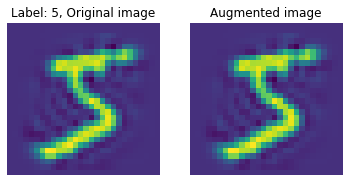

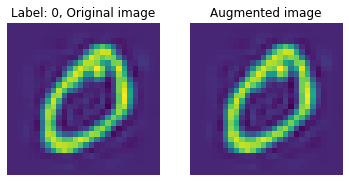

In [ ]:
def show(image, augmented_img, label):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis('off'), ax2.axis('off')

    g = ax1.imshow(image)
    ax1.set_title(f'Label: {np.argmax(label.numpy())}, Original image')
    g = ax2.imshow(augmented_img)
    ax2.set_title(f'Augmented image')


for image, label in dataset_train.take(2):
    augmented_img = random_rotate_image(image)
    augmented_img = random_shift_image(augmented_img)
    augmented_img = random_zoom_image(augmented_img)
    show(np.reshape(image, (28, 28)), np.reshape(augmented_img, (28, 28)), label)

In [ ]:
dataset_train = dataset_train_aug.shuffle(buffer_size=1024).batch(batch_size)

# Model Design

In this model, we set the weights of the final layer to represent the distribution of the dataset. This is really useful for this unbalanced dataset (i.e. not a needed step for this one).

In [ ]:
def bias_init(shape, dtype=None):
    bias = np.array([label_distribution[i]/dataset_length for i in range(shape[0])])
    return bias

def build_model(input_shape, output_shape):
    x = Input(shape=input_shape)

    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
    hidden = Conv2D(32, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = Conv2D(64, kernel_size=(3, 3), activation='relu')(hidden)
    hidden = MaxPool2D((2, 2))(hidden)
    hidden = Dropout(0.2)(hidden)
    hidden = BatchNormalization()(hidden)

    hidden = Conv2D(128, kernel_size = (3,3), activation ='relu')(hidden)
    hidden = Flatten()(hidden)

    hidden = Dense(128, activation='relu')(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(0.2)(hidden)

    y = Dense(output_shape, activation='softmax', bias_initializer=bias_init)(hidden)

    return Model(inputs=x, outputs=y)

model = build_model((x_train.shape[1], x_train.shape[2], 1), 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496 

## Custom Training Loop



In [ ]:
class CustomModel(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super(CustomModel, self).__init__(**kwargs)

        self.model = model

        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

        self.acc = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.loss_metric = tf.keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [
            self.acc,
            self.loss_metric
        ]

    @tf.function
    def test_step(self, data):
        x, y = data

        # Inference on test set
        y_pred = self.model(x, training=False)
        
        # Update metrics
        self.acc.update_state(y, y_pred)
        return {
            "Accuracy": self.acc.result(),
        }

    @tf.function
    def train_step(self, data):
        x_batch, y_batch = data

        # Forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)
            total_loss = self.loss_fn(y_batch, y_pred)

        # Backpropagation
        grads = tape.gradient(total_loss, self.model.trainable_weights)

        # Weigth update
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update training metric
        self.acc.update_state(y_batch, y_pred)
        self.loss_metric.update_state(total_loss)
        return {
            "Accuracy": self.acc.result(),
            "Categorical Cross Entropy": self.loss_metric.result(),
        }

In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
cm = CustomModel(model)
cm.compile(optimizer)
cm.evaluate(dataset_train)

In [ ]:
history = cm.fit(dataset_train, epochs=3, validation_data=dataset_val)

Epoch 1/3
1875/1875 [==============================] - 76s 23ms/step - Accuracy: 0.8700 - Categorical Cross Entropy: 0.4205 - val_Accuracy: 0.9876
Epoch 2/3
1875/1875 [==============================] - 44s 23ms/step - Accuracy: 0.9727 - Categorical Cross Entropy: 0.0875 - val_Accuracy: 0.9920
Epoch 3/3
1875/1875 [==============================] - 44s 23ms/step - Accuracy: 0.9818 - Categorical Cross Entropy: 0.0645 - val_Accuracy: 0.9948


# Interpretability

Let's explore the outputs of some of the convolutional layers to determine if they are analysing noise or picking up on an actual signal.

In [ ]:
def get_layer_output(model, idx, sample):
    assert idx < len(model.layers)
    assert idx > -2

    try:
        data_flow = K.function([model.layers[0].input],
                            [model.layers[idx].output])
        return data_flow(sample)
    except:
        print("Cannot get the layer")
        return None

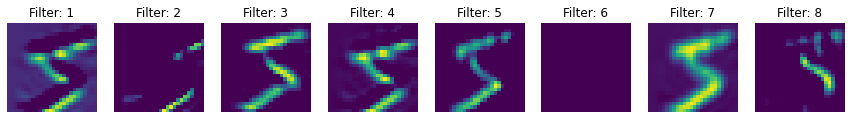

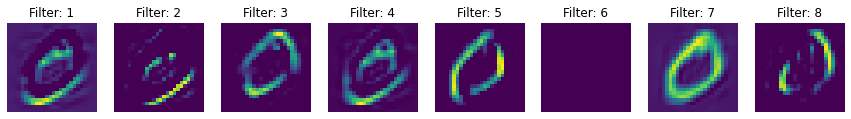

In [ ]:
def show_vfeats(image1, image2, image3, image4, image5, image6, image7, image8):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(15,15))
    ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off')
    ax5.axis('off'), ax6.axis('off'), ax7.axis('off'), ax8.axis('off')

    g = ax1.imshow(image1)
    ax1.set_title(f'Filter: {1}')
    g = ax2.imshow(image2)
    ax2.set_title(f'Filter: {2}')
    g = ax3.imshow(image3)
    ax3.set_title(f'Filter: {3}')
    g = ax4.imshow(image4)
    ax4.set_title(f'Filter: {4}')
    g = ax5.imshow(image5)
    ax5.set_title(f'Filter: {5}')
    g = ax6.imshow(image6)
    ax6.set_title(f'Filter: {6}')
    g = ax7.imshow(image7)
    ax7.set_title(f'Filter: {7}')
    g = ax8.imshow(image8)
    ax8.set_title(f'Filter: {8}')

for image, label in dataset_train_aug.take(2):
    vfeat = get_layer_output(model, 1, np.array([image]))[0]

    show_vfeats(
        np.reshape(vfeat[0, :, :, 0], (26, 26)),
        np.reshape(vfeat[0, :, :, 1], (26, 26)),
        np.reshape(vfeat[0, :, :, 2], (26, 26)),
        np.reshape(vfeat[0, :, :, 3], (26, 26)),
        np.reshape(vfeat[0, :, :, 4], (26, 26)),
        np.reshape(vfeat[0, :, :, 5], (26, 26)),
        np.reshape(vfeat[0, :, :, 6], (26, 26)),
        np.reshape(vfeat[0, :, :, 7], (26, 26))
        )

# Model Evaluation

Let us look at where the model is wrong with the confusion matrix (we will see if patterns of errors are recurrent).

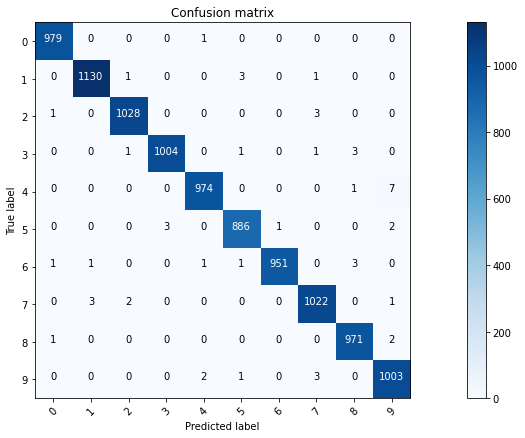

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

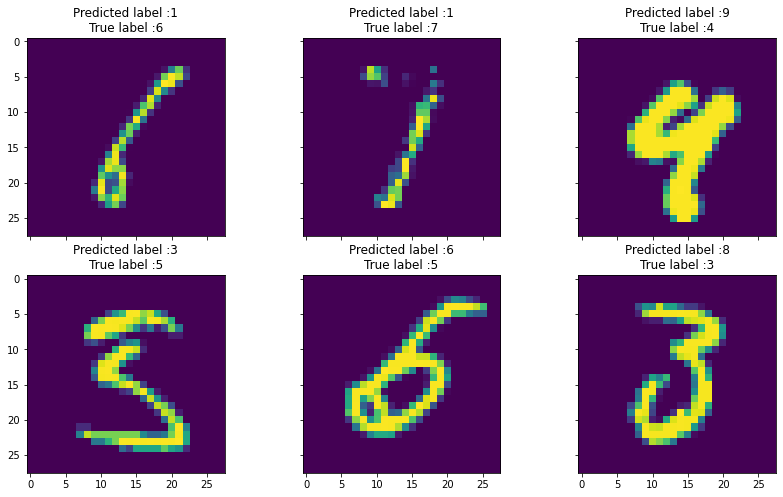

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(14,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)